In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
from scipy import ndimage
from tqdm import tqdm

In [ ]:
def clear_layers(viewer):
    layers = viewer.layers
    while len(layers) > 0:
        layers.remove(layers[0])

# Generate random XY, ZX, and ZY slices from a training dataset

In [ ]:
import numpy as np
from numpy.random import randint
from tifffile import imread, imwrite
from tqdm import tqdm
import os

def get_rand_slices(im: np.ndarray, samples = 3):
    ''' 
    Returns a dictionary of random XY, XZ, and YZ slices from a 3D stack.
    Parameters: im - a 3D stack
                samples - the number of slices for each dimension to return
    Returns:    a dictionary of slices labeled with their dimension and index
    '''
    assert im.ndim == 3, 'Image must be 3D'
    d = {}
    z,y,x = im.shape
    for n in range(samples):
        randyx = randint(0,z)
        randzx = randint(0,y)
        randzy = randint(0,x)
        d[f"randyx_{randyx}_#{n}"]=im[randyx]
        d[f"randzx_{randzx}_#{n}"]=im[:,randzx]
        d[f"randzy_{randzy}_#{n}"]=im[:,:,randzy]
    return d

source = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ_sbdl2'
dest = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ_sbdl2_random_slices'
if not os.path.exists(dest):
    os.mkdir(dest)
names = [f for f in os.listdir(source) if f.endswith('_16bit_scaleZ_sbdl2_16bit.tif') and not f.startswith('.')]
for name in tqdm(names):
    im = imread(source +'/'+name)
    justname = name.split('.')[0]
    slices = get_rand_slices(im, samples = 3)
    for k,v in slices.items():
        imwrite(f'{dest}/{justname}_{k}.tif',v)

# Augment dataset by artificially turning xy slices into xz slices by adding 1D Gaussian Blur

#### Example of synthetic training data

In [ ]:
og_path = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V2/220710_Fix_Em_Flvw_Mix_PI_aTub647_E02-Z01_PI_16bit_randyx_164_#1.tif'
og = imread(og_path)
# a Gaussian filter with a standard deviation of 10
gauss = ndimage.gaussian_filter1d(og, 7, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200)
ax1.imshow(og, cmap='gray', vmin = 0, vmax=15000)
ax2.imshow(gauss, cmap='gray', vmin = 0, vmax=15000)

get rid of the log processed files, and existing ortho projections

In [ ]:
target_dir = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V3/new_gauss/'

# make a list of files with "log" in the name
delete_list = [f for f in os.listdir(target_dir) if 'log' in f or 'zx' in f or 'zy' in f]
# delete the files
for f in delete_list:
    os.remove(os.path.join(target_dir, f))

ims = [f for f in os.listdir(target_dir) if f.endswith('tif') and 'yx' in f and not f.startswith('.')]

Gaussian blur the images

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
from scipy import ndimage
from tqdm import tqdm

with tqdm(total = len(ims)) as pbar:
    for im in ims:
        im_path = os.path.join(target_dir, im)
        im_data = imread(im_path)
        im_data = ndimage.gaussian_filter1d(im_data, 7.5, 0)
        imwrite(im_path, im_data)
        pbar.update(1)

Rename in the images and .npy files

In [ ]:
tifs = [f for f in os.listdir(target_dir) if f.endswith('.tif') and not f.startswith('.')]
segs = [f for f in os.listdir(target_dir) if f.endswith('.npy') and not f.startswith('.')]

for f in tifs:
    base = f.split('.')[0]
    newname = base + '_gauss.tif'
    os.rename(os.path.join(target_dir, f), os.path.join(target_dir, newname))

for s in segs:
    base = s.split('_seg.npy')[0]
    newname = base + '_gauss_seg.npy'
    os.rename(os.path.join(target_dir, s), os.path.join(target_dir, newname))

# Convert .npy files to labels and save as tif files

This is necessary for training cellpose in GDrive

In [ ]:
from tifffile import imwrite
import numpy as np
from tqdm import tqdm
import shutil
import os

# dir containing ...tif and ..._seg.npy files
raw_dir = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V2' 
tifs = [f for f in os.listdir(raw_dir) if f.endswith('.tif') and not f.startswith('.')]
segs = [f for f in os.listdir(raw_dir) if f.endswith('.npy') and not f.startswith('.')]

# create save directories
base_save_dir = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V2_GD'
image_save_dir = os.path.join(base_save_dir, 'Images')
mask_save_dir = os.path.join(base_save_dir, 'Masks')
if not os.path.exists(image_save_dir):
    os.makedirs(image_save_dir)
if not os.path.exists(mask_save_dir):
    os.makedirs(mask_save_dir)

# copy all tifs to the image save dir
for f in tifs:
    shutil.copy(os.path.join(raw_dir, f), image_save_dir)

# extract the masks out of each of the seg files and save as tif to the mask save dir
with tqdm(total=len(segs)) as pbar:
    for s in segs:
        item = np.load(os.path.join(raw_dir, s), allow_pickle=True).item()
        masks = item['masks']
        save_name = s.split('_seg.npy')[0] + '.tif'
        imwrite(os.path.join(mask_save_dir, save_name), masks)
        pbar.update(1)

Convert a single npy file into masks

In [ ]:
from tifffile import imwrite
import numpy as np
import os

# dir containing ...tif and ..._seg.npy files
dir = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ_sbdl2'
name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Cntrl_E02-Z01_PI_16bit_scaleZ_sbdl2_16bit_seg.npy' 

# create save directories
item = np.load(os.path.join(dir, name), allow_pickle=True).item()
masks = item['masks']
save_name = name.split('_seg.npy')[0] + '_Masks_Fused.tif'
imwrite(os.path.join(dir, save_name), masks, imagej=True, metadata={'axes': 'ZYX'})

# Batch process volumes with DoG filters

In [ ]:
import os
from tqdm import tqdm
from skimage import filters
from tifffile import imread, imwrite

processing_dir = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ'
save_dir = os.path.join(processing_dir, 'sbdl2_processed')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

im_names = [f for f in os.listdir(processing_dir) if f.endswith('.tif') and not f.startswith('.')]

with tqdm(total=len(im_names)) as pbar:
    for im_name in im_names:
        im_base = im_name.split('.')[0]
        im = imread(os.path.join(processing_dir, im_name))
        sbdl2 = filters.difference_of_gaussians(im, low_sigma=2, high_sigma=128)
        # save as 32 bit float
        imwrite(os.path.join(save_dir, f'{im_base}_sbdl2.tif'), sbdl2.astype('float32'), imagej=True, metadata={'axes': 'ZYX'})
        pbar.update(1)

# remove a label and re-save

In [ ]:
from tifffile import imread, imwrite
import numpy as np
import os

base = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/U-Net_3D/' 
name = '220624_Fix_Flvw_Emb_PI_Utr647_E02-10X-Z01_downsample_log_Crop_46-98_Target.tif' 
masks = imread(os.path.join(base, name))
base_name = name.split('.')[0]
masks[masks == 63] = 0
imwrite(os.path.join(base, base_name + '_corr.tif'), masks, imagej=True, metadata={'axes': 'ZYX'})


# Turn instance segmentation into semantic segmentation

#### Example:

In [ ]:
from tifffile import imread, imwrite
from scipy import ndimage
import os
import numpy as np
import matplotlib.pyplot as plt

dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training/Target'
sem_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Exp_E10-Z01_PI_16bit_scaleZ_crop_40-61_crop_Target.tif' 
sem = imread(os.path.join(dir, sem_name))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(sem[15], cmap='Set3')

# iterate through all of the labels in sem, and erode them
labels = np.unique(sem)
binary = np.zeros(sem.shape)

for label in labels:
    if label == 0:
        continue
    else:
        mask = sem == label
        mask = ndimage.binary_erosion(mask, iterations = 2)
        binary[mask] = 1

ax2.imshow(binary[15], cmap='Set3')

#### Batch processing:

In [ ]:
from tifffile import imread, imwrite
from scipy import ndimage
import os
import numpy as np
from tqdm import tqdm

base_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training' 
mask_dir = os.path.join(base_dir, 'Target')
source_dir = os.path.join(base_dir, 'Source')
mask_names = [f for f in os.listdir(mask_dir) if f.endswith('.tif') and not f.startswith('.')]

save_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training_binary_8bit_3'
mask_save_dir = os.path.join(save_dir, 'Target')
source_save_dir = os.path.join(save_dir, 'Source')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(mask_save_dir):
    os.makedirs(mask_save_dir)
if not os.path.exists(source_save_dir):
    os.makedirs(source_save_dir)

for mask_name in tqdm(mask_names):
    sem = imread(os.path.join(mask_dir, mask_name))
    labels = np.unique(sem)
    binary = np.zeros(sem.shape)
    for label in labels:
        if label == 0:
            continue
        else:
            mask = sem == label
            mask = ndimage.binary_erosion(mask, iterations = 2)
            binary[mask] = 1
    imwrite(os.path.join(mask_save_dir, mask_name), binary[2:-2,2:-2,2:-2].astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})
    mask_base = mask_name.split('Target.tif')[0]
    source_name = mask_base + 'Source.tif'
    source = imread(os.path.join(source_dir, source_name))
    imwrite(os.path.join(source_save_dir, source_name), source[2:-2,2:-2,2:-2].astype('uint16'), imagej=True, metadata={'axes': 'ZYX'})

# turn instance into multiclass semantic segmentation

In [ ]:
from tifffile import imread, imwrite
from scipy import ndimage
import os
import numpy as np
from tqdm import tqdm

# source dirs and names
base_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training' 
mask_dir = os.path.join(base_dir, 'Target')
source_dir = os.path.join(base_dir, 'Source')
mask_names = [f for f in os.listdir(mask_dir) if f.endswith('.tif') and not f.startswith('.')]

# dest dirs and names
save_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training_multiclass_8bit_1'
mask_save_dir = os.path.join(save_dir, 'Target')
source_save_dir = os.path.join(save_dir, 'Source')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(mask_save_dir):
    os.makedirs(mask_save_dir)
if not os.path.exists(source_save_dir):
    os.makedirs(source_save_dir)

# make the changes. background pixels are set to 0, edges are 1, cytoplasm is 2
for mask_name in tqdm(mask_names):
    instance_labels = imread(os.path.join(mask_dir, mask_name))
    labels = np.unique(instance_labels)
    binary = np.zeros(instance_labels.shape)
    for label in labels:
        if label == 0:
            continue
        else:
            mask = instance_labels == label
            eroded = ndimage.binary_erosion(mask, iterations = 2)
            binary[mask] = 1
            binary[eroded] = 2
    imwrite(os.path.join(mask_save_dir, mask_name), binary[2:-2,2:-2,2:-2].astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})
    mask_base = mask_name.split('Target.tif')[0]
    source_name = mask_base + 'Source.tif'
    source = imread(os.path.join(source_dir, source_name))
    imwrite(os.path.join(source_save_dir, source_name), source[2:-2,2:-2,2:-2].astype('uint16'), imagej=True, metadata={'axes': 'ZYX'})

# Convert file to 8-bit

In [ ]:
from tifffile import imread, imwrite
import os
from tqdm import tqdm

base_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training_Binary_8bit' 
mask_dir = os.path.join(base_dir, 'Target')
source_dir = os.path.join(base_dir, 'Source')
mask_names = [f for f in os.listdir(mask_dir) if f.endswith('.tif') and not f.startswith('.')]

for mask_name in tqdm(mask_names):
    mask = imread(os.path.join(mask_dir, mask_name))
    imwrite(os.path.join(mask_dir, mask_name), mask.astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})
    mask_base = mask_name.split('Target.tif')[0]
    source_name = mask_base + 'Source.tif'
    source = imread(os.path.join(source_dir, source_name))
    imwrite(os.path.join(source_dir, source_name), source[1:-1].astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})

# Elastic deform

In [ ]:
import os
import numpy as np
import napari
import raster_geometry as rg
import tifffile as tif
%gui qt 

In [ ]:
viewer = napari.Viewer()

In [ ]:
import elasticdeform

clear_layers(viewer)
sphere = rg.sphere(125,40)
ints = np.zeros(sphere.shape, dtype=int)
ints[sphere] = 1
print(np.unique(ints))
viewer.add_image(sphere, name='sphere', blending='additive', colormap='green')
deformed = elasticdeform.deform_random_grid(ints, sigma=0.005, points=30)
viewer.add_image(deformed, name='deformed', blending='additive', colormap='red')
print(np.unique(deformed))

In [ ]:
from skimage.draw import line_aa
from skimage.draw import line_nd
from tqdm import tqdm

clear_layers(viewer)

object_num = 500

ROI_size = 500

start_x = np.random.randint(0,ROI_size)
end_x = np.random.randint(0, ROI_size)

start_y = np.random.randint(0,ROI_size)
end_y = np.random.randint(0, ROI_size)

start_z =  np.random.randint(0, ROI_size)
end_z =  np.random.randint(0, ROI_size)

canvas_vol = np.zeros((ROI_size, ROI_size, ROI_size))

for t in tqdm(range(object_num)):
    indice = [np.random.randint(0, ROI_size) for i in range(6)]
    
    start_pt, end_pt = indice[:3], indice[3:]
    
    line_pts = line_nd(start_pt, end_pt) 

    for i in range(len(line_pts[0])):
        canvas_vol[line_pts[0][i], line_pts[1][i], line_pts[2][i]] = 1#(2**16-1)*(2/3)  

viewer.add_image(canvas_vol, name='canvas', blending='additive', colormap='magenta')
deformed = elasticdeform.deform_random_grid(canvas_vol, sigma=3, points=70)
viewer.add_image(deformed, name='deformed', blending='additive', colormap='green')
print(np.unique(canvas_vol))
print(np.unique(deformed))

# Filtering low quality segmentations:

In [ ]:
import os
import numpy as np
import napari
from tifffile import imread, imwrite
from skimage import morphology
from tqdm import tqdm
%gui qt 
viewer = napari.Viewer()

#### Read the data:

In [2]:
base_dir = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ' 
masks_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Exp_E02-Z01_PI_16bit_scaleZ_seg_masks.tif'
tub_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Exp_E01-Z01_Tub_16bit_scaleZ.tif' 

masks = imread(os.path.join(base_dir, masks_name))
tub = imread(os.path.join(base_dir, tub_name))
labels = np.unique(masks)

#### Useful methods:

In [3]:
def wipe_layers():
    '''
    Delete all layers in the viewer objected
    '''
    layers = viewer.layers
    while len(layers) > 0:
        layers.remove(layers[0])

def remove_large_objects(labels_array: np.ndarray, max_size: int) -> np.ndarray:
    ''' 
    Remove all objects in a mask above a specific threshold
    '''
    out = np.copy(labels_array)
    component_sizes = np.bincount(labels_array.ravel()) # count the number of pixels in different labels
    too_big = component_sizes > max_size
    too_big_mask = too_big[labels_array]
    out[too_big_mask] = 0
    return out

#### Let's look at the distribution of label sizes:

In [4]:
label_IDs = np.unique(masks)
print(f'identified {len(label_IDs)} labels')
label_volumes = []
for label_ID in tqdm(label_IDs):
    label_volume = np.sum(masks == label_ID)
    label_volumes.append(label_volume)

print(f'smallest label size: {min(label_volumes)}')
print(f'largest label size: {max(label_volumes)}')
print(f'average label size: {np.mean(label_volumes)}')
print(f'median label size: {np.median(label_volumes)}')

identified 200 labels


100%|██████████| 200/200 [00:32<00:00,  6.13it/s]

smallest label size: 17
largest label size: 99432681
average label size: 878592.0
median label size: 71220.5


#### Filter out all labels smaller than half the median size or larger than n times the median size:

In [5]:
minimum_size = np.mean(label_volumes) / 2
maximum_size = np.mean(label_volumes) * 2
wipe_layers()
print(f'removing objects smaller than {minimum_size}')
filtered_masks = morphology.remove_small_objects(masks, min_size=minimum_size, connectivity=1)
print(f'removing objects larger than {maximum_size}')
filtered_masks = remove_large_objects(filtered_masks, max_size=maximum_size)
viewer.add_labels(filtered_masks, name='filtered_masks', blending='additive')

removing objects smaller than 439296.0
removing objects larger than 1757184.0


<Labels layer 'filtered_masks' at 0x1123b5250>

#### pick a "good" and "bad" label to play with:

In [6]:
good_id = 129
bad_id = 20
good_points = np.column_stack(np.where(filtered_masks == good_id))
bad_points = np.column_stack(np.where(filtered_masks == bad_id))
print(f'collection of good points with shape {good_points.shape}')
print(f'collection of bad points with shape {bad_points.shape}')

collection of good points with shape (734536, 3)
collection of bad points with shape (551132, 3)


#### Calculate the Betti numbers for each point cloud:
https://giotto-ai.github.io/gtda-docs/0.4.0/notebooks/classifying_shapes.html

First, let's filter the point clouds to save ourselves some computing time:

In [13]:
clouds_to_analyze = [good_points, bad_points]
for pc_index, pc in enumerate(clouds_to_analyze):
    if pc.shape[0] < 1000:
        continue
    scale_factor = 500
    print(f'large point cloud with {pc.shape[0]} points detected. Downsizing by a factor of {scale_factor}')
    np.random.shuffle(clouds_to_analyze[pc_index])
    clouds_to_analyze[pc_index] = clouds_to_analyze[pc_index][::int(scale_factor)]
    print(f'randomized point cloud and selected every {int(scale_factor)} points to filter down to {pc.shape[0]} points')

large point cloud with 734536 points detected. Reducing to ~1000 points
randomized point cloud and selected every 734 points to filter down to 734536 points
large point cloud with 551132 points detected. Reducing to ~1000 points
randomized point cloud and selected every 551 points to filter down to 551132 points


In [14]:
print(clouds_to_analyze[0].shape)

(1001, 3)


In [15]:
from gtda.homology import VietorisRipsPersistence

# Track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

diagrams_basic = persistence.fit_transform(clouds_to_analyze)

In [18]:
from gtda.plotting import plot_diagram

# good points
plot_diagram(diagrams_basic[0])
# bad points
plot_diagram(diagrams_basic[1])

#### Calculate the peristence entropy of the points:

In [20]:
from gtda.diagrams import PersistenceEntropy

persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
X_basic = persistence_entropy.fit_transform(diagrams_basic)

# expect shape - (n_point_clouds, n_homology_dims)
X_basic

array([[9.88492277, 8.32234983, 6.16379686],
       [9.87356755, 8.27093709, 6.03833114]])

In [22]:
from gtda.plotting import plot_point_cloud
plot_point_cloud(X_basic)

#### Let's pick out a handful of good labels and bad labels to see if we can discriminate between them:

In [28]:
good_labels = [184, 150, 129, 151, 132]
bad_labels = [20, 33, 14, 118, 103]

good_label_pcs = [np.column_stack(np.where(filtered_masks == good_id)) for good_id in good_labels]
bad_label_pcs = [np.column_stack(np.where(filtered_masks == bad_id)) for bad_id in bad_labels]

In [29]:
def filter_points(l: list) -> list:
    for pc_index, pc in enumerate(l):
        if pc.shape[0] < 1000:
            continue
        scale_factor = 500
        print(f'large point cloud with {pc.shape[0]} points detected.')
        np.random.shuffle(l[pc_index])
        l[pc_index] = l[pc_index][::int(scale_factor)]
        print(f'randomized point cloud and selected every {int(scale_factor)} points to filter down to {l[pc_index].shape[0]} points')
    return l

print(f'pc with shape {good_label_pcs[0].shape} at index 0 before filtering')
good_label_pcs = filter_points(good_label_pcs)
bad_label_pcs = filter_points(bad_label_pcs)
print(f'pc with shape {good_label_pcs[0].shape} at index 0 after filtering')

pc with shape (726690, 3) at index 0 before filtering
large point cloud with 726690 points detected.
randomized point cloud and selected every 500 points to filter down to 1454 points
large point cloud with 1000848 points detected.
randomized point cloud and selected every 500 points to filter down to 2002 points
large point cloud with 734536 points detected.
randomized point cloud and selected every 500 points to filter down to 1470 points
large point cloud with 665647 points detected.
randomized point cloud and selected every 500 points to filter down to 1332 points
large point cloud with 796756 points detected.
randomized point cloud and selected every 500 points to filter down to 1594 points
large point cloud with 551132 points detected.
randomized point cloud and selected every 500 points to filter down to 1103 points
large point cloud with 1355610 points detected.
randomized point cloud and selected every 500 points to filter down to 2712 points
large point cloud with 1000477 poi

In [30]:
good_diagrams_basic = persistence.fit_transform(good_label_pcs)
bad_diagrams_basic = persistence.fit_transform(bad_label_pcs)
good_X_basic = persistence_entropy.fit_transform(good_diagrams_basic)
bad_X_basic = persistence_entropy.fit_transform(bad_diagrams_basic)

good_X_basic.shape

(5, 3)

In [38]:
print(good_X_basic.T[0])
print(bad_X_basic)

[10.42523982 10.88288718 10.43913403 10.2987316  10.55668155]
[[10.01556958  8.46993202  6.3297205 ]
 [11.29933626  9.8053938   7.6714278 ]
 [10.87840931  9.30503386  7.12157398]
 [10.25931137  8.77211327  6.48520277]
 [ 9.91210722  8.3809308   5.99494322]]


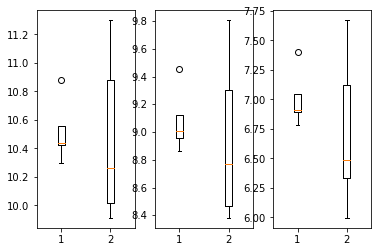

In [43]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.boxplot([good_X_basic.T[0], bad_X_basic.T[0]])
ax2.boxplot([good_X_basic.T[1], bad_X_basic.T[1]])
ax3.boxplot([good_X_basic.T[2], bad_X_basic.T[2]])
plt.show()

In [46]:
plot_point_cloud(good_X_basic)

In [48]:
plot_point_cloud(bad_X_basic)

wtf is up with masks 18, 19, and 20

In [6]:
weird_masks = [18,19,20,98]
for mask_id in weird_masks:
    print(f'size of mask ID {mask_id} is {np.sum(big_filtered == mask_id)}')

size of mask ID 18 is 220950
size of mask ID 19 is 691732
size of mask ID 20 is 930786
size of mask ID 98 is 960524


In [10]:
viewer.add_labels(big_filtered, name='big_filtered')

<Labels layer 'big_filtered [1]' at 0x1ab9f3ee0>

In [12]:
from tqdm import tqdm
import matplotlib.pyplot as plt

remaining_labels = np.unique(big_filtered)

100%|██████████| 87/87 [01:21<00:00,  1.06it/s]


In [17]:
label_vols = []
for label in tqdm(remaining_labels):
    if label == 0:
        continue
    label_vols.append(np.sum(big_filtered == label))

100%|██████████| 87/87 [01:28<00:00,  1.01s/it]


minimum volume is 30805
maximum volume is 997084
average volume is 484050.38372093026
median volume is 512493.0


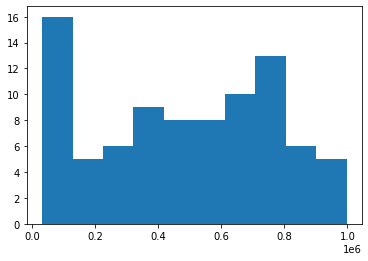

In [20]:
plt.hist(label_vols, bins=10)
print(f'minimum volume is {min(label_vols)}')
print(f'maximum volume is {max(label_vols)}')
print(f'average volume is {np.mean(label_vols)}')
print(f'median volume is {np.median(label_vols)}')
plt.show()

---
experimenting with apoc

In [ ]:
im_dir = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ' 
im_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Cntrl_E01-Z01_Tub_16bit_scaleZ.tif' 
labels_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Cntrl_E01-Z01_Tub_16bit_scaleZ_human-labels.tif' 
im = imread(os.path.join(im_dir, im_name))
labels = imread(os.path.join(im_dir, labels_name))
viewer.add_image(im, name='im', blending='additive', colormap='gray')
viewer.add_labels(labels, name='labels', blending='additive')

In [ ]:
# get layers from viewer
layers = viewer.layers
output = layers['Result of PixelClassifier.cl'].data
annotations = layers["Labels"].data
save_dir = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ' 
output_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Cntrl_E01-Z01_Tub_16bit_scaleZ_apoc-seg.tif'
labels_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Cntrl_E01-Z01_Tub_16bit_scaleZ_human-labels.tif'
imwrite(os.path.join(save_dir, output_name), output.astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})
imwrite(os.path.join(save_dir, labels_name), annotations.astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})